# **Imports 📢**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy
from tqdm import tqdm

# **Dataset 🗂️**

## Read Dataset

In [2]:
!unzip ./data/mobile_price.zip -d ./data/

Archive:  ./data/mobile_price.zip
  inflating: ./data/test.csv         
  inflating: ./data/train.csv        


In [2]:
df = pd.read_csv('./data/train.csv')
X = df.drop('price_range', axis=1)
y = df['price_range']

## Split

In [3]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, random_state=42)

## Preprocess

In [4]:
x_train = torch.FloatTensor(x_train.values)
y_train = torch.LongTensor(y_train.values)

x_valid = torch.FloatTensor(x_valid.values)
y_valid = torch.LongTensor(y_valid.values)

mu = x_train.mean(dim=0)
std = x_train.std(dim=0)

x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

## Dataloader

In [5]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, 20, True)

valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=200)

# **Model 🧠**

In [6]:
num_feats = 20
num_class = 4

h1 = 64
h2 = 32

model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      # nn.Dropout(0.5),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

In [7]:
model[0].bias

Parameter containing:
tensor([ 0.0106,  0.1780,  0.1582,  0.1597,  0.1032, -0.1757, -0.1799,  0.2029,
        -0.0736,  0.0856, -0.1616,  0.0610,  0.0917, -0.0190, -0.0951, -0.0428,
         0.0986, -0.2031, -0.0694, -0.1646,  0.0753, -0.0329,  0.1161, -0.0804,
         0.0588, -0.0117, -0.0031, -0.1093,  0.2140,  0.2088, -0.1407, -0.0254,
        -0.0618,  0.0229,  0.0096, -0.1584,  0.0499,  0.1273,  0.0109,  0.0442,
         0.1099,  0.0237,  0.1465,  0.0333,  0.0564, -0.0341,  0.1414,  0.0855,
         0.2065,  0.1666, -0.2192,  0.0839, -0.1110,  0.0487,  0.2185, -0.1178,
        -0.0498,  0.0042,  0.0531, -0.2201,  0.1584,  0.1716, -0.1401,  0.1744],
       requires_grad=True)

# **Loss & Optimizer ⚖️**

In [8]:
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),
                      lr=0.01,
                      momentum=0.9,
                      nesterov=True,
                      weight_decay=1e-4)    # L2Regularization

# **Device ⚙️**

In [9]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
model = model.to(device)

# **Utils 🧰**

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [11]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=num_class).to(device)
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())

      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())

  return model, loss_train.avg, acc_train.compute().item()

In [12]:
def evaluate(model, valid_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=num_class).to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())

  return loss_valid.avg, acc_valid.compute()

# **Train**

In [12]:
for i in tqdm(range(50000000)):
  j = i**2

100%|██████████| 50000000/50000000 [00:16<00:00, 3016269.31it/s]


In [13]:
num_epochs = 100

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

for epoch in range(num_epochs):
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)

  loss_valid, acc_valid = evaluate(model,
                                   valid_loader,
                                   loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  print(f'Valid: Loss={loss_valid:.4}, Accuracy={acc_valid:.4}\n')

Epoch 0: 100%|██████████| 70/70 [00:00<00:00, 110.12batch/s, accuracy=30.5, loss=1.37]


Valid: Loss=1.329, Accuracy=0.4633



Epoch 1: 100%|██████████| 70/70 [00:00<00:00, 182.06batch/s, accuracy=53.8, loss=1.15]


Valid: Loss=0.8542, Accuracy=0.6767



Epoch 2: 100%|██████████| 70/70 [00:00<00:00, 182.66batch/s, accuracy=81.6, loss=0.614]


Valid: Loss=0.4475, Accuracy=0.8867



Epoch 3: 100%|██████████| 70/70 [00:00<00:00, 182.06batch/s, accuracy=92, loss=0.352]  


Valid: Loss=0.301, Accuracy=0.9133



Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 190.02batch/s, accuracy=93.2, loss=0.245]


Valid: Loss=0.2389, Accuracy=0.93



Epoch 5: 100%|██████████| 70/70 [00:00<00:00, 195.97batch/s, accuracy=94.7, loss=0.182]


Valid: Loss=0.2192, Accuracy=0.9167



Epoch 6: 100%|██████████| 70/70 [00:00<00:00, 164.25batch/s, accuracy=95.4, loss=0.153]


Valid: Loss=0.2026, Accuracy=0.9233



Epoch 7: 100%|██████████| 70/70 [00:00<00:00, 179.10batch/s, accuracy=95.9, loss=0.132]


Valid: Loss=0.1983, Accuracy=0.9133



Epoch 8: 100%|██████████| 70/70 [00:00<00:00, 162.05batch/s, accuracy=96.4, loss=0.111] 


Valid: Loss=0.1837, Accuracy=0.9217



Epoch 9: 100%|██████████| 70/70 [00:00<00:00, 191.80batch/s, accuracy=97.1, loss=0.0996]


Valid: Loss=0.1796, Accuracy=0.91



Epoch 10: 100%|██████████| 70/70 [00:00<00:00, 192.00batch/s, accuracy=97.9, loss=0.0798]


Valid: Loss=0.174, Accuracy=0.92



Epoch 11: 100%|██████████| 70/70 [00:00<00:00, 180.84batch/s, accuracy=98, loss=0.071]   


Valid: Loss=0.1906, Accuracy=0.9167



Epoch 12: 100%|██████████| 70/70 [00:00<00:00, 170.35batch/s, accuracy=98.3, loss=0.0666]


Valid: Loss=0.1815, Accuracy=0.9033



Epoch 13: 100%|██████████| 70/70 [00:00<00:00, 163.55batch/s, accuracy=98.9, loss=0.0563]


Valid: Loss=0.1815, Accuracy=0.92



Epoch 14: 100%|██████████| 70/70 [00:00<00:00, 156.68batch/s, accuracy=98.9, loss=0.0499]


Valid: Loss=0.1893, Accuracy=0.9067



Epoch 15: 100%|██████████| 70/70 [00:00<00:00, 176.30batch/s, accuracy=99.2, loss=0.0442]


Valid: Loss=0.1916, Accuracy=0.9083



Epoch 16: 100%|██████████| 70/70 [00:00<00:00, 199.36batch/s, accuracy=98.9, loss=0.0448]


Valid: Loss=0.1823, Accuracy=0.9117



Epoch 17: 100%|██████████| 70/70 [00:00<00:00, 192.60batch/s, accuracy=99, loss=0.0379]  


Valid: Loss=0.2148, Accuracy=0.8967



Epoch 18: 100%|██████████| 70/70 [00:00<00:00, 185.76batch/s, accuracy=99.4, loss=0.0342]


Valid: Loss=0.1726, Accuracy=0.9267



Epoch 19: 100%|██████████| 70/70 [00:00<00:00, 185.98batch/s, accuracy=99.7, loss=0.0271]


Valid: Loss=0.2115, Accuracy=0.9



Epoch 20: 100%|██████████| 70/70 [00:00<00:00, 165.18batch/s, accuracy=99.9, loss=0.024] 


Valid: Loss=0.1796, Accuracy=0.925



Epoch 21: 100%|██████████| 70/70 [00:00<00:00, 180.80batch/s, accuracy=99.9, loss=0.0217]


Valid: Loss=0.1882, Accuracy=0.9183



Epoch 22: 100%|██████████| 70/70 [00:00<00:00, 167.08batch/s, accuracy=99.9, loss=0.0193]


Valid: Loss=0.188, Accuracy=0.9133



Epoch 23: 100%|██████████| 70/70 [00:00<00:00, 189.44batch/s, accuracy=99.9, loss=0.0164]


Valid: Loss=0.1905, Accuracy=0.92



Epoch 24: 100%|██████████| 70/70 [00:00<00:00, 201.56batch/s, accuracy=100, loss=0.0148]


Valid: Loss=0.1948, Accuracy=0.9133



Epoch 25: 100%|██████████| 70/70 [00:00<00:00, 200.56batch/s, accuracy=100, loss=0.0127]


Valid: Loss=0.1948, Accuracy=0.91



Epoch 26: 100%|██████████| 70/70 [00:00<00:00, 190.50batch/s, accuracy=100, loss=0.0117]


Valid: Loss=0.1999, Accuracy=0.91



Epoch 27: 100%|██████████| 70/70 [00:00<00:00, 207.96batch/s, accuracy=100, loss=0.0107] 


Valid: Loss=0.2066, Accuracy=0.9067



Epoch 28: 100%|██████████| 70/70 [00:00<00:00, 205.67batch/s, accuracy=100, loss=0.0103] 


Valid: Loss=0.1937, Accuracy=0.9183



Epoch 29: 100%|██████████| 70/70 [00:00<00:00, 194.13batch/s, accuracy=100, loss=0.00954]


Valid: Loss=0.2047, Accuracy=0.915



Epoch 30: 100%|██████████| 70/70 [00:00<00:00, 203.31batch/s, accuracy=100, loss=0.00858]


Valid: Loss=0.2082, Accuracy=0.91



Epoch 31: 100%|██████████| 70/70 [00:00<00:00, 200.57batch/s, accuracy=100, loss=0.00812]


Valid: Loss=0.2067, Accuracy=0.91



Epoch 32: 100%|██████████| 70/70 [00:00<00:00, 187.26batch/s, accuracy=100, loss=0.00767]


Valid: Loss=0.2122, Accuracy=0.9033



Epoch 33: 100%|██████████| 70/70 [00:00<00:00, 143.57batch/s, accuracy=100, loss=0.00722]


Valid: Loss=0.2105, Accuracy=0.9067



Epoch 34: 100%|██████████| 70/70 [00:00<00:00, 164.47batch/s, accuracy=100, loss=0.00698]


Valid: Loss=0.2098, Accuracy=0.915



Epoch 35: 100%|██████████| 70/70 [00:00<00:00, 170.80batch/s, accuracy=100, loss=0.00656]


Valid: Loss=0.2176, Accuracy=0.9183



Epoch 36: 100%|██████████| 70/70 [00:00<00:00, 161.37batch/s, accuracy=100, loss=0.00617]


Valid: Loss=0.2142, Accuracy=0.9067



Epoch 37: 100%|██████████| 70/70 [00:00<00:00, 148.10batch/s, accuracy=100, loss=0.00591]


Valid: Loss=0.211, Accuracy=0.91



Epoch 38: 100%|██████████| 70/70 [00:00<00:00, 149.01batch/s, accuracy=100, loss=0.00563]


Valid: Loss=0.2118, Accuracy=0.9133



Epoch 39: 100%|██████████| 70/70 [00:00<00:00, 158.66batch/s, accuracy=100, loss=0.00548]


Valid: Loss=0.2178, Accuracy=0.9083



Epoch 40: 100%|██████████| 70/70 [00:00<00:00, 148.06batch/s, accuracy=100, loss=0.00526]


Valid: Loss=0.2151, Accuracy=0.9117



Epoch 41: 100%|██████████| 70/70 [00:00<00:00, 166.95batch/s, accuracy=100, loss=0.00488]


Valid: Loss=0.222, Accuracy=0.9167



Epoch 42: 100%|██████████| 70/70 [00:00<00:00, 145.71batch/s, accuracy=100, loss=0.00483]


Valid: Loss=0.2119, Accuracy=0.9067



Epoch 43: 100%|██████████| 70/70 [00:00<00:00, 147.82batch/s, accuracy=100, loss=0.00464]


Valid: Loss=0.2231, Accuracy=0.9133



Epoch 44: 100%|██████████| 70/70 [00:00<00:00, 134.31batch/s, accuracy=100, loss=0.00438]


Valid: Loss=0.2208, Accuracy=0.9117



Epoch 45: 100%|██████████| 70/70 [00:00<00:00, 159.68batch/s, accuracy=100, loss=0.00426]


Valid: Loss=0.217, Accuracy=0.9117



Epoch 46: 100%|██████████| 70/70 [00:00<00:00, 166.56batch/s, accuracy=100, loss=0.00405]


Valid: Loss=0.2231, Accuracy=0.9117



Epoch 47: 100%|██████████| 70/70 [00:00<00:00, 149.16batch/s, accuracy=100, loss=0.00401]


Valid: Loss=0.2282, Accuracy=0.9117



Epoch 48: 100%|██████████| 70/70 [00:00<00:00, 167.12batch/s, accuracy=100, loss=0.00387]


Valid: Loss=0.2222, Accuracy=0.9167



Epoch 49: 100%|██████████| 70/70 [00:00<00:00, 165.54batch/s, accuracy=100, loss=0.00371]


Valid: Loss=0.2249, Accuracy=0.9133



Epoch 50: 100%|██████████| 70/70 [00:00<00:00, 176.02batch/s, accuracy=100, loss=0.00361]


Valid: Loss=0.2278, Accuracy=0.9133



Epoch 51: 100%|██████████| 70/70 [00:00<00:00, 177.13batch/s, accuracy=100, loss=0.0035] 


Valid: Loss=0.2308, Accuracy=0.91



Epoch 52: 100%|██████████| 70/70 [00:00<00:00, 158.38batch/s, accuracy=100, loss=0.0035] 


Valid: Loss=0.2322, Accuracy=0.91



Epoch 53: 100%|██████████| 70/70 [00:00<00:00, 172.65batch/s, accuracy=100, loss=0.00326]


Valid: Loss=0.231, Accuracy=0.9133



Epoch 54: 100%|██████████| 70/70 [00:00<00:00, 171.10batch/s, accuracy=100, loss=0.00322]


Valid: Loss=0.2323, Accuracy=0.9083



Epoch 55: 100%|██████████| 70/70 [00:00<00:00, 172.06batch/s, accuracy=100, loss=0.00311]


Valid: Loss=0.2311, Accuracy=0.9083



Epoch 56: 100%|██████████| 70/70 [00:00<00:00, 170.21batch/s, accuracy=100, loss=0.00308]


Valid: Loss=0.2288, Accuracy=0.9133



Epoch 57: 100%|██████████| 70/70 [00:00<00:00, 164.11batch/s, accuracy=100, loss=0.00298]


Valid: Loss=0.2335, Accuracy=0.91



Epoch 58: 100%|██████████| 70/70 [00:00<00:00, 162.61batch/s, accuracy=100, loss=0.00291]


Valid: Loss=0.2359, Accuracy=0.9067



Epoch 59: 100%|██████████| 70/70 [00:00<00:00, 167.34batch/s, accuracy=100, loss=0.00292]


Valid: Loss=0.2339, Accuracy=0.9133



Epoch 60: 100%|██████████| 70/70 [00:00<00:00, 163.04batch/s, accuracy=100, loss=0.00284]


Valid: Loss=0.2303, Accuracy=0.9133



Epoch 61: 100%|██████████| 70/70 [00:00<00:00, 161.42batch/s, accuracy=100, loss=0.00273]


Valid: Loss=0.237, Accuracy=0.9133



Epoch 62: 100%|██████████| 70/70 [00:00<00:00, 165.52batch/s, accuracy=100, loss=0.00267]


Valid: Loss=0.2347, Accuracy=0.9133



Epoch 63: 100%|██████████| 70/70 [00:00<00:00, 169.30batch/s, accuracy=100, loss=0.00262]


Valid: Loss=0.2337, Accuracy=0.9083



Epoch 64: 100%|██████████| 70/70 [00:00<00:00, 161.96batch/s, accuracy=100, loss=0.0026] 


Valid: Loss=0.2371, Accuracy=0.91



Epoch 65: 100%|██████████| 70/70 [00:00<00:00, 175.78batch/s, accuracy=100, loss=0.00251]


Valid: Loss=0.2413, Accuracy=0.9117



Epoch 66: 100%|██████████| 70/70 [00:00<00:00, 164.26batch/s, accuracy=100, loss=0.00248]


Valid: Loss=0.2387, Accuracy=0.91



Epoch 67: 100%|██████████| 70/70 [00:00<00:00, 164.19batch/s, accuracy=100, loss=0.00245]


Valid: Loss=0.2405, Accuracy=0.9133



Epoch 68: 100%|██████████| 70/70 [00:00<00:00, 168.62batch/s, accuracy=100, loss=0.00239]


Valid: Loss=0.2394, Accuracy=0.9133



Epoch 69: 100%|██████████| 70/70 [00:00<00:00, 153.13batch/s, accuracy=100, loss=0.00232]


Valid: Loss=0.242, Accuracy=0.9117



Epoch 70: 100%|██████████| 70/70 [00:00<00:00, 176.09batch/s, accuracy=100, loss=0.00232]


Valid: Loss=0.2403, Accuracy=0.91



Epoch 71: 100%|██████████| 70/70 [00:00<00:00, 161.41batch/s, accuracy=100, loss=0.00227]


Valid: Loss=0.244, Accuracy=0.9117



Epoch 72: 100%|██████████| 70/70 [00:00<00:00, 162.88batch/s, accuracy=100, loss=0.0022] 


Valid: Loss=0.2483, Accuracy=0.9083



Epoch 73: 100%|██████████| 70/70 [00:00<00:00, 163.16batch/s, accuracy=100, loss=0.00218]


Valid: Loss=0.2433, Accuracy=0.9117



Epoch 74: 100%|██████████| 70/70 [00:00<00:00, 166.71batch/s, accuracy=100, loss=0.00213]


Valid: Loss=0.2444, Accuracy=0.9133



Epoch 75: 100%|██████████| 70/70 [00:00<00:00, 159.14batch/s, accuracy=100, loss=0.0021] 


Valid: Loss=0.2428, Accuracy=0.91



Epoch 76: 100%|██████████| 70/70 [00:00<00:00, 162.90batch/s, accuracy=100, loss=0.00207]


Valid: Loss=0.2464, Accuracy=0.91



Epoch 77: 100%|██████████| 70/70 [00:00<00:00, 178.28batch/s, accuracy=100, loss=0.00205]


Valid: Loss=0.2491, Accuracy=0.91



Epoch 78: 100%|██████████| 70/70 [00:00<00:00, 165.67batch/s, accuracy=100, loss=0.00202]


Valid: Loss=0.2461, Accuracy=0.9117



Epoch 79: 100%|██████████| 70/70 [00:00<00:00, 157.45batch/s, accuracy=100, loss=0.00199]


Valid: Loss=0.2481, Accuracy=0.91



Epoch 80: 100%|██████████| 70/70 [00:00<00:00, 174.29batch/s, accuracy=100, loss=0.00196]


Valid: Loss=0.2504, Accuracy=0.9067



Epoch 81: 100%|██████████| 70/70 [00:00<00:00, 151.84batch/s, accuracy=100, loss=0.00194]


Valid: Loss=0.2471, Accuracy=0.9133



Epoch 82: 100%|██████████| 70/70 [00:00<00:00, 168.42batch/s, accuracy=100, loss=0.0019] 


Valid: Loss=0.2483, Accuracy=0.91



Epoch 83: 100%|██████████| 70/70 [00:00<00:00, 162.29batch/s, accuracy=100, loss=0.00188]


Valid: Loss=0.2478, Accuracy=0.91



Epoch 84: 100%|██████████| 70/70 [00:00<00:00, 175.61batch/s, accuracy=100, loss=0.00185]


Valid: Loss=0.249, Accuracy=0.91



Epoch 85: 100%|██████████| 70/70 [00:00<00:00, 154.92batch/s, accuracy=100, loss=0.00183]


Valid: Loss=0.2524, Accuracy=0.9083



Epoch 86: 100%|██████████| 70/70 [00:00<00:00, 165.68batch/s, accuracy=100, loss=0.00182]


Valid: Loss=0.2507, Accuracy=0.9117



Epoch 87: 100%|██████████| 70/70 [00:00<00:00, 164.66batch/s, accuracy=100, loss=0.00178]


Valid: Loss=0.2499, Accuracy=0.9117



Epoch 88: 100%|██████████| 70/70 [00:00<00:00, 172.02batch/s, accuracy=100, loss=0.00178]


Valid: Loss=0.2488, Accuracy=0.9117



Epoch 89: 100%|██████████| 70/70 [00:00<00:00, 170.06batch/s, accuracy=100, loss=0.00174]


Valid: Loss=0.2503, Accuracy=0.9117



Epoch 90: 100%|██████████| 70/70 [00:00<00:00, 154.75batch/s, accuracy=100, loss=0.00173]


Valid: Loss=0.2513, Accuracy=0.91



Epoch 91: 100%|██████████| 70/70 [00:00<00:00, 170.35batch/s, accuracy=100, loss=0.0017] 


Valid: Loss=0.253, Accuracy=0.91



Epoch 92: 100%|██████████| 70/70 [00:00<00:00, 169.63batch/s, accuracy=100, loss=0.00171]


Valid: Loss=0.2549, Accuracy=0.9133



Epoch 93: 100%|██████████| 70/70 [00:00<00:00, 171.65batch/s, accuracy=100, loss=0.00167]


Valid: Loss=0.2517, Accuracy=0.9117



Epoch 94: 100%|██████████| 70/70 [00:00<00:00, 172.18batch/s, accuracy=100, loss=0.00168]


Valid: Loss=0.2536, Accuracy=0.91



Epoch 95: 100%|██████████| 70/70 [00:00<00:00, 154.89batch/s, accuracy=100, loss=0.00165]


Valid: Loss=0.2539, Accuracy=0.91



Epoch 96: 100%|██████████| 70/70 [00:00<00:00, 170.87batch/s, accuracy=100, loss=0.00164]


Valid: Loss=0.2551, Accuracy=0.91



Epoch 97: 100%|██████████| 70/70 [00:00<00:00, 162.54batch/s, accuracy=100, loss=0.00159]


Valid: Loss=0.2573, Accuracy=0.91



Epoch 98: 100%|██████████| 70/70 [00:00<00:00, 167.67batch/s, accuracy=100, loss=0.00158]


Valid: Loss=0.2567, Accuracy=0.9117



Epoch 99: 100%|██████████| 70/70 [00:00<00:00, 169.07batch/s, accuracy=100, loss=0.00157]


Valid: Loss=0.2559, Accuracy=0.91



# **Plot**

### Loss

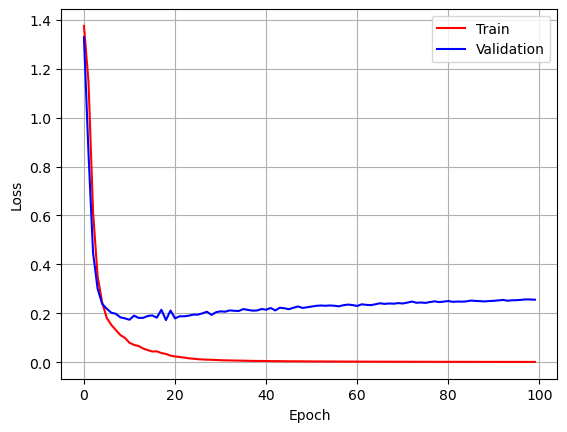

In [14]:
plt.plot(range(num_epochs), loss_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

### Accuracy

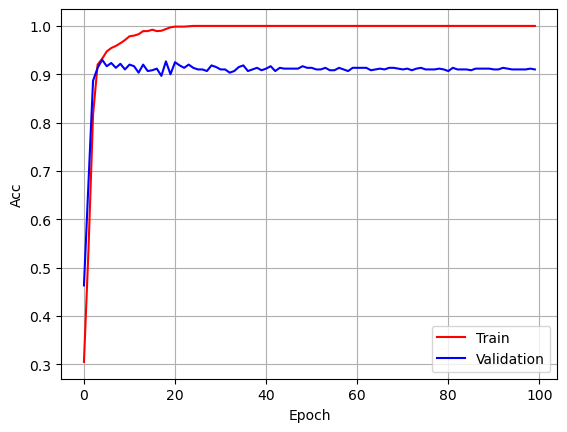

In [15]:
plt.plot(range(num_epochs), acc_train_hist, 'r-', label='Train')
plt.plot(range(num_epochs), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

In [16]:
state_dict = model.state_dict()

In [20]:
!mkdir ./out/

In [17]:
torch.save(state_dict, './out/weights.pt')

In [18]:
wb = torch.load('./out/weights.pt')
model.load_state_dict(wb)

<All keys matched successfully>

# **Efficient way for set hyperparams 🔨**

In [19]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

## Step 1: check forward path

Calculate loss for one batch

In [23]:
x_batch, y_batch = next(iter(train_loader))
yp = model(x_batch)
loss_fn(yp, y_batch)

tensor(1.3863, grad_fn=<NllLossBackward0>)

## Step 2: check backward path

Select 5 random batches and overfit the model

In [24]:
mini_train_dataset, _ = random_split(dataset=train_dataset, lengths=(100, len(train_dataset) - 100))
mini_loader = DataLoader(mini_train_dataset, 20, shuffle=True)

In [27]:
for epoch in range(500):    # after 1500 epoch
    model, _, _ = train_one_epoch(model, mini_loader, loss_fn, optimizer, epoch)

Epoch 499: 100%|██████████| 5/5 [00:00<00:00, 126.79batch/s, accuracy=100, loss=0.00555]


## Step 3: select best lr

Train all data for one epoch

In [ ]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=..., weight_decay=...)

In [28]:
for lr in [0.1, 0.01, 0.001, 0.0001]:
  model = nn.Sequential(nn.Linear(num_feats, h1),
                        nn.ReLU(),
                        nn.Linear(h1, h2),
                        nn.ReLU(),
                        nn.Linear(h2, num_class))

  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)

  print(f'LR={lr}')
  for epoch in range(5):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.1


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 181.87batch/s, accuracy=92.8, loss=0.221]



LR=0.01


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 175.98batch/s, accuracy=45.5, loss=1.32]



LR=0.001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 174.97batch/s, accuracy=34.9, loss=1.37]



LR=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 167.23batch/s, accuracy=25.4, loss=1.39]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=..., weight_decay=...)

In [29]:
for lr in [0.1, 0.15, 0.2, 0.25, 0.3]:
  for wd in [0., 1e-4, 1e-5, 1e-6]:
    model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    print(f'LR={lr}, WD={wd}')
    for epoch in range(5):
      model, _, _ = train_one_epoch(model,
                                    train_loader,
                                    loss_fn,
                                    optimizer,
                                    epoch)
    print()
    # torch.save(...)

LR=0.1, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 171.21batch/s, accuracy=93.4, loss=0.214]



LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 153.66batch/s, accuracy=93.3, loss=0.214]



LR=0.1, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 150.58batch/s, accuracy=92.8, loss=0.212]



LR=0.1, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 163.06batch/s, accuracy=93, loss=0.2]    



LR=0.15, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 175.66batch/s, accuracy=93, loss=0.177]  



LR=0.15, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 161.37batch/s, accuracy=92.9, loss=0.189]



LR=0.15, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 169.52batch/s, accuracy=91.4, loss=0.202]



LR=0.15, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 168.09batch/s, accuracy=92.1, loss=0.197]



LR=0.2, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 161.43batch/s, accuracy=88.9, loss=0.263]



LR=0.2, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 166.95batch/s, accuracy=90.8, loss=0.253]



LR=0.2, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 149.69batch/s, accuracy=91.4, loss=0.235]



LR=0.2, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 150.84batch/s, accuracy=91.1, loss=0.237]



LR=0.25, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 177.82batch/s, accuracy=86.4, loss=0.316]



LR=0.25, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 71.89batch/s, accuracy=89.7, loss=0.266] 



LR=0.25, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 110.30batch/s, accuracy=85.6, loss=0.38] 



LR=0.25, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 82.19batch/s, accuracy=88.9, loss=0.293]



LR=0.3, WD=0.0


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 129.63batch/s, accuracy=86, loss=0.363]  



LR=0.3, WD=0.0001


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 115.23batch/s, accuracy=87.6, loss=0.329]



LR=0.3, WD=1e-05


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 106.45batch/s, accuracy=88.5, loss=0.335]



LR=0.3, WD=1e-06


Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 111.42batch/s, accuracy=90.4, loss=0.224]

### Pretty table

In [31]:
from prettytable import PrettyTable

l = [["Hassan", 21, "LUMS"], ["Ali", 22, "FAST"], ["Ahmed", 23, "UET"]]
table = PrettyTable(['Name', 'Age', 'University'])

for rec in l:
    table.add_row(rec)

print(table)

+--------+-----+------------+
|  Name  | Age | University |
+--------+-----+------------+
| Hassan |  21 |    LUMS    |
|  Ali   |  22 |    FAST    |
| Ahmed  |  23 |    UET     |
+--------+-----+------------+


## Step 5: train more epochs

In [32]:
model = nn.Sequential(nn.Linear(num_feats, h1),
                      nn.ReLU(),
                      nn.Linear(h1, h2),
                      nn.ReLU(),
                      nn.Linear(h2, num_class))

optimizer = optim.SGD(model.parameters(), lr=0.15, weight_decay=1e-5)

In [33]:
num_epochs = 20

In [34]:
best_valid_loss = torch.inf

In [35]:
for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn)

  if loss_valid < best_valid_loss:
    torch.save(model, './model/model.pt')
    best_valid_loss = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}\n')

Epoch 0: 100%|██████████| 70/70 [00:00<00:00, 140.19batch/s, accuracy=56.1, loss=1.07]


Model Saved!
Valid: Loss = 0.614, Acc = 0.8033



Epoch 1: 100%|██████████| 70/70 [00:00<00:00, 144.35batch/s, accuracy=86.9, loss=0.446]


Model Saved!
Valid: Loss = 0.3224, Acc = 0.9033



Epoch 2: 100%|██████████| 70/70 [00:00<00:00, 165.37batch/s, accuracy=89.4, loss=0.287]


Model Saved!
Valid: Loss = 0.2312, Acc = 0.92



Epoch 3: 100%|██████████| 70/70 [00:00<00:00, 157.90batch/s, accuracy=91.4, loss=0.22] 


Valid: Loss = 0.2527, Acc = 0.8967



Epoch 4: 100%|██████████| 70/70 [00:00<00:00, 167.59batch/s, accuracy=91.1, loss=0.236]


Valid: Loss = 0.2685, Acc = 0.8767



Epoch 5: 100%|██████████| 70/70 [00:00<00:00, 162.02batch/s, accuracy=92.7, loss=0.205]


Valid: Loss = 0.5945, Acc = 0.7883



Epoch 6: 100%|██████████| 70/70 [00:00<00:00, 166.20batch/s, accuracy=94.2, loss=0.144]


Valid: Loss = 0.3155, Acc = 0.8483



Epoch 7: 100%|██████████| 70/70 [00:00<00:00, 148.11batch/s, accuracy=95, loss=0.137]  


Model Saved!
Valid: Loss = 0.2133, Acc = 0.9



Epoch 8: 100%|██████████| 70/70 [00:00<00:00, 162.75batch/s, accuracy=95.4, loss=0.132]


Valid: Loss = 0.3105, Acc = 0.8733



Epoch 9: 100%|██████████| 70/70 [00:00<00:00, 153.64batch/s, accuracy=95.9, loss=0.107] 


Valid: Loss = 0.2546, Acc = 0.9067



Epoch 10: 100%|██████████| 70/70 [00:00<00:00, 162.34batch/s, accuracy=94.7, loss=0.153] 


Valid: Loss = 0.4159, Acc = 0.8617



Epoch 11: 100%|██████████| 70/70 [00:00<00:00, 165.10batch/s, accuracy=95.5, loss=0.118]


Valid: Loss = 0.2485, Acc = 0.8933



Epoch 12: 100%|██████████| 70/70 [00:00<00:00, 155.48batch/s, accuracy=96.3, loss=0.121] 


Valid: Loss = 0.2966, Acc = 0.8883



Epoch 13: 100%|██████████| 70/70 [00:00<00:00, 163.15batch/s, accuracy=97.5, loss=0.0707]


Valid: Loss = 0.3135, Acc = 0.8817



Epoch 14: 100%|██████████| 70/70 [00:00<00:00, 156.86batch/s, accuracy=98.4, loss=0.0521]


Valid: Loss = 0.2618, Acc = 0.8917



Epoch 15: 100%|██████████| 70/70 [00:00<00:00, 164.60batch/s, accuracy=99, loss=0.0354]  


Valid: Loss = 0.2907, Acc = 0.8983



Epoch 16: 100%|██████████| 70/70 [00:00<00:00, 156.50batch/s, accuracy=98.6, loss=0.0341]


Valid: Loss = 0.3117, Acc = 0.875



Epoch 17: 100%|██████████| 70/70 [00:00<00:00, 147.42batch/s, accuracy=96.1, loss=0.116] 


Valid: Loss = 0.755, Acc = 0.825



Epoch 18: 100%|██████████| 70/70 [00:00<00:00, 147.03batch/s, accuracy=95.1, loss=0.139]


Valid: Loss = 0.492, Acc = 0.8517



Epoch 19: 100%|██████████| 70/70 [00:00<00:00, 164.37batch/s, accuracy=95.9, loss=0.141] 


Valid: Loss = 0.4543, Acc = 0.875

